In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

from pyinterpolate.io_ops import prepare_areal_shapefile, get_points_within_area  # Prepare data
from pyinterpolate.semivariance import calculate_semivariance  # Experimental semivariogram
from pyinterpolate.semivariance import RegularizedSemivariogram  # Semivariogram regularization class
from pyinterpolate.semivariance import TheoreticalSemivariogram
from pyinterpolate.kriging import ArealKriging

import matplotlib.pyplot as plt


areal_data = 'cancer_data.shp'
point_data = 'cancer_population_base.shp'

areal_id = 'FIPS'
areal_val = 'rate'
points_val = 'POP10'

areal_data_prepared = prepare_areal_shapefile(areal_data, areal_id, areal_val)

points_in_area = get_points_within_area(areal_data, point_data, areal_id_col_name=areal_id, points_val_col_name=points_val)

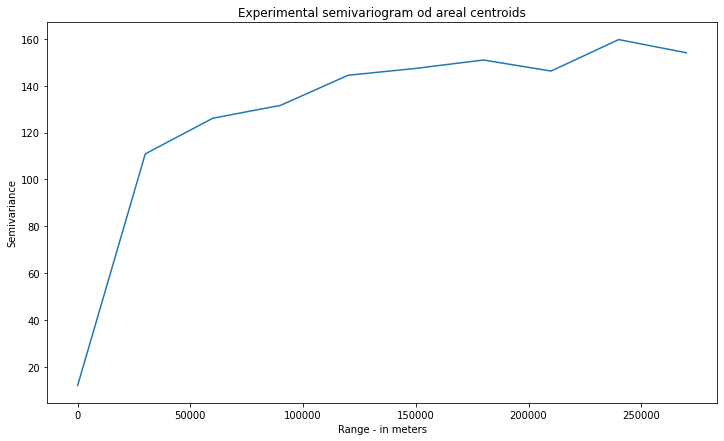

In [3]:
maximum_range = 300000
step_size = 30000

dt = areal_data_prepared[:, 2:]  # x, y, val
exp_semivar = calculate_semivariance(data=dt, step_size=step_size, max_range=maximum_range)

# Plot experimental semivariogram

plt.figure(figsize=(12, 7))
plt.plot(exp_semivar[:, 0], exp_semivar[:, 1])
plt.title('Experimental semivariogram od areal centroids')
plt.xlabel('Range - in meters')
plt.ylabel('Semivariance')
plt.show()

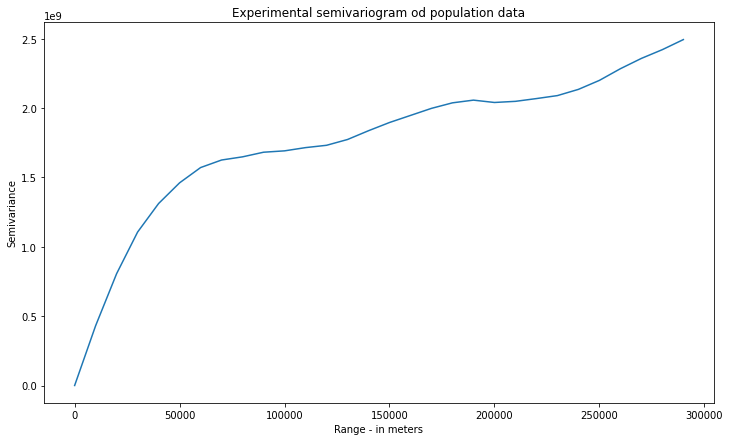

In [4]:
def build_point_array(points):
    a = None

    for rec in points:
        if a is None:
            a = rec.copy()
        else:
            a = np.vstack((a, rec))

    return a

maximum_point_range = 300000
step_size_points = 10000


pt = build_point_array(points_in_area[:, 1])  # x, y, val
exp_semivar = calculate_semivariance(data=pt, step_size=step_size_points, max_range=maximum_point_range)

# Plot experimental semivariogram

plt.figure(figsize=(12, 7))
plt.plot(exp_semivar[:, 0], exp_semivar[:, 1])
plt.title('Experimental semivariogram od population data')
plt.xlabel('Range - in meters')
plt.ylabel('Semivariance')
plt.show()

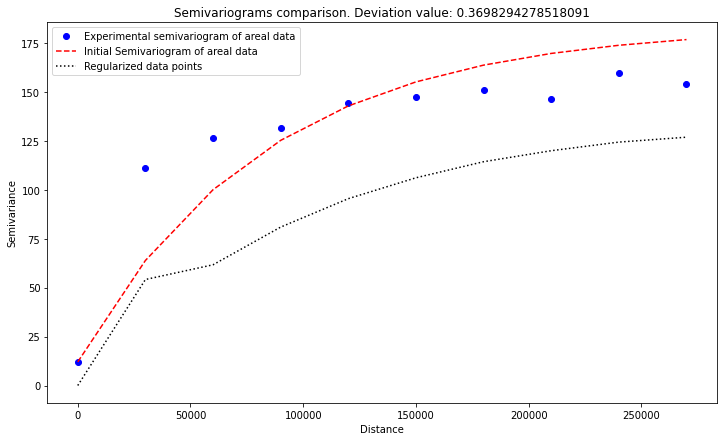

In [6]:
reg_mod = RegularizedSemivariogram()

reg_mod.fit(areal_data=areal_data_prepared,
            areal_step_size=step_size,
            max_areal_range=maximum_range,
            point_support_data=points_in_area,
            weighted_lags=True,
            store_models=False)

# Check initial experimental, theoretical and regularized semivariograms

lags = reg_mod.experimental_semivariogram_of_areal_data[:, 0]

plt.figure(figsize=(12, 7))
plt.plot(lags, reg_mod.experimental_semivariogram_of_areal_data[:, 1], 'ob')
plt.plot(lags, reg_mod.initial_theoretical_model_of_areal_data.predict(lags), color='r', linestyle='--')
plt.plot(lags, reg_mod.initial_regularized_model, color='black', linestyle='dotted')
plt.legend(['Experimental semivariogram of areal data', 'Initial Semivariogram of areal data',
            'Regularized data points'])
plt.title('Semivariograms comparison. Deviation value: {}'.format(reg_mod.initial_deviation))
plt.xlabel('Distance')
plt.ylabel('Semivariance')
plt.show()

In [7]:
reg_mod.transform(max_iters=5)

100%|██████████| 5/5 [03:48<00:00, 45.76s/it]


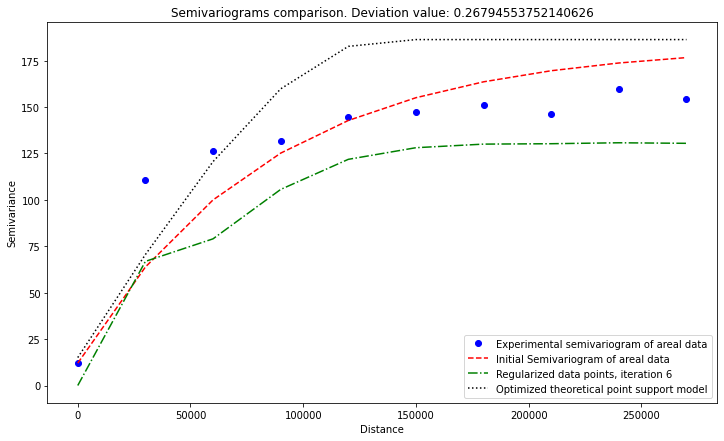

In [8]:
lags = reg_mod.experimental_semivariogram_of_areal_data[:, 0]
plt.figure(figsize=(12, 7))
plt.plot(lags, reg_mod.experimental_semivariogram_of_areal_data[:, 1], 'bo')
plt.plot(lags, reg_mod.initial_theoretical_model_of_areal_data.predict(lags), color='r', linestyle='--')
plt.plot(lags, reg_mod.optimal_regularized_model, color='g', linestyle='-.')
plt.plot(lags, reg_mod.optimal_theoretical_model.predict(lags), color='black', linestyle='dotted')
plt.legend(['Experimental semivariogram of areal data', 
            'Initial Semivariogram of areal data',
            'Regularized data points, iteration {}'.format(reg_mod.iter),
            'Optimized theoretical point support model'])
plt.title('Semivariograms comparison. Deviation value: {}'.format(reg_mod.optimal_deviation))
plt.xlabel('Distance')
plt.ylabel('Semivariance')
plt.show()

In [9]:
reg_mod.export_regularized_model('regularized_model_covid.csv')

In [10]:
semivariogram = TheoreticalSemivariogram()  # Create TheoreticalSemivariogram object
semivariogram.import_model('regularized_model_covid.csv')  # Load regularized semivariogram


In [14]:
number_of_obs = 16
radius = 30000

# Get crs

gdf_crs = gpd.read_file(areal_data).crs

kriging_model = ArealKriging(semivariogram_model=semivariogram,
    known_areas=areal_data_prepared,
    known_areas_points=points_in_area,
    kriging_type='atp')

smoothed_area = kriging_model.regularize_data(number_of_neighbours=number_of_obs,
                                              max_search_radius=radius,
                                              data_crs=gdf_crs)

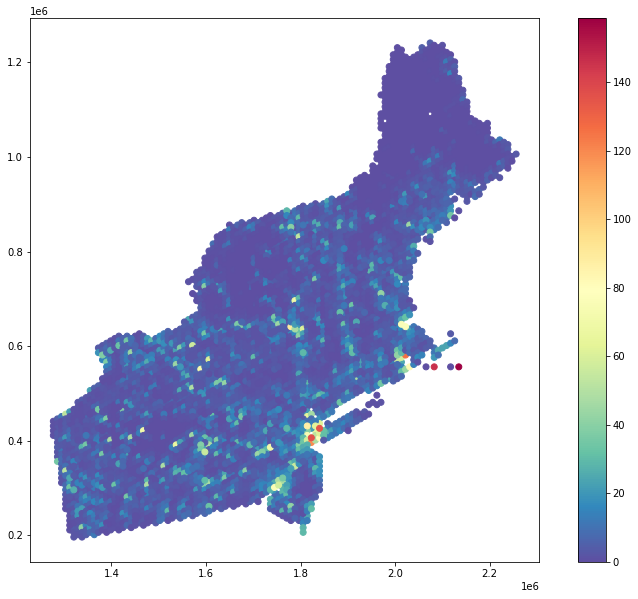

In [15]:
fs = (14, 10)
output_map = smoothed_area.copy()
output_map.plot(column='reg.est', cmap='Spectral_r', legend=True, figsize=fs)

output_map.to_file('smoothed_output.shp')

___